# T08 - Implementasi Generative Adevsarial Network

## ANGGOTA KELOMPOK


1.   HIkam Ibnu - 442303611044
2.   M Rizqi Anugrah - 442303611041
3.   Dziffar J - 442303611055
4.   Arifin Zulfan - 442303611043
5.   Rahmat Abdurrahman - 442023611047


# 1. IMPORT LIBRARY

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import time

tf.random.set_seed(42)
np.random.seed(42)

# 2. LOAD DAN PREPROCESSING

Dataset shape: (60000, 28, 28, 1)
Data range: [-1.00, 1.00]


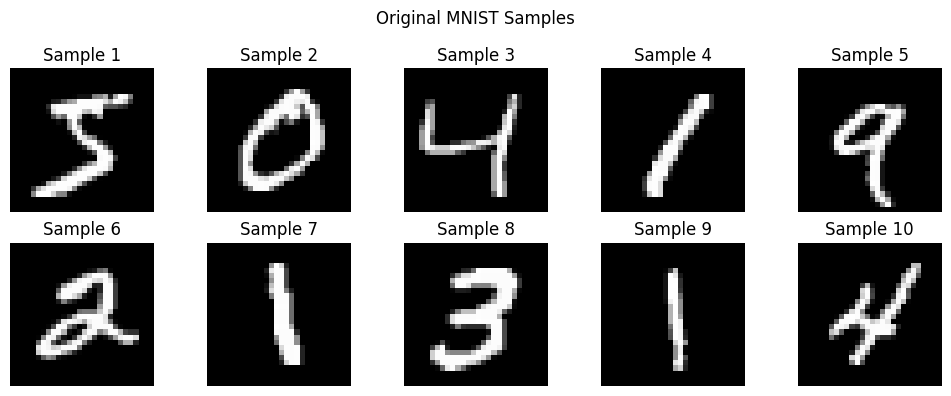

In [3]:
# Load dataset MNIST (lebih mudah untuk GAN pertama)
(x_train, _), (_, _) = keras.datasets.mnist.load_data()

# Preprocessing
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize ke [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

print(f"Dataset shape: {x_train.shape}")
print(f"Data range: [{x_train.min():.2f}, {x_train.max():.2f}]")

# Visualisasi sample data
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Sample {i+1}')
    plt.axis('off')
plt.suptitle('Original MNIST Samples')
plt.tight_layout()
plt.show()

# 3. CREATE GENERATOR MODEL

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


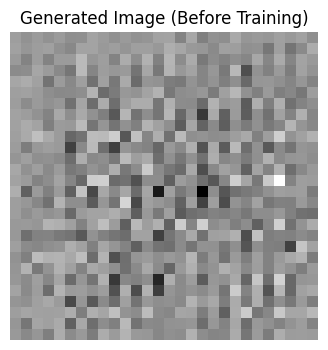

Generator Architecture:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [4]:
def create_generator(latent_dim=100):
    """
    Generator: Mengubah noise menjadi gambar
    Input: Random noise vector (latent_dim,)
    Output: Generated image (28, 28, 1)
    """
    model = keras.Sequential([
        # Dense layer untuk expand noise
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Reshape ke format image
        layers.Reshape((7, 7, 256)),

        # Upsampling layers
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ], name='generator')

    return model

# Create generator
latent_dim = 100
generator = create_generator(latent_dim)

# Test generator
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.figure(figsize=(4, 4))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Generated Image (Before Training)')
plt.axis('off')
plt.show()

print("Generator Architecture:")
generator.summary()

# 4. CREATE DISCRIMINATOR MODEL

In [5]:
def create_discriminator():
    """
    Discriminator: Membedakan gambar real vs fake
    Input: Image (28, 28, 1)
    Output: Probability (real/fake)
    """
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')

    return model

# Create discriminator
discriminator = create_discriminator()

# Test discriminator
decision = discriminator(generated_image, training=False)
print(f"Discriminator decision on generated image: {decision.numpy()[0][0]:.4f}")

print("\nDiscriminator Architecture:")
discriminator.summary()

Discriminator decision on generated image: 0.5002

Discriminator Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

# 5. DEFINISI LOSS FUNCTION DAN OPTIMIZING

In [6]:
# Binary cross entropy loss
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss:
    - Real images should be classified as 1
    - Fake images should be classified as 0
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Generator loss:
    - Fake images should fool discriminator (classified as 1)
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# 6. TRAINING FUNCTION

In [7]:
@tf.function
def train_step(images, batch_size, latent_dim):
    """
    Training step untuk GAN
    """
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Discriminator predictions
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 7. TRAINING LOOP

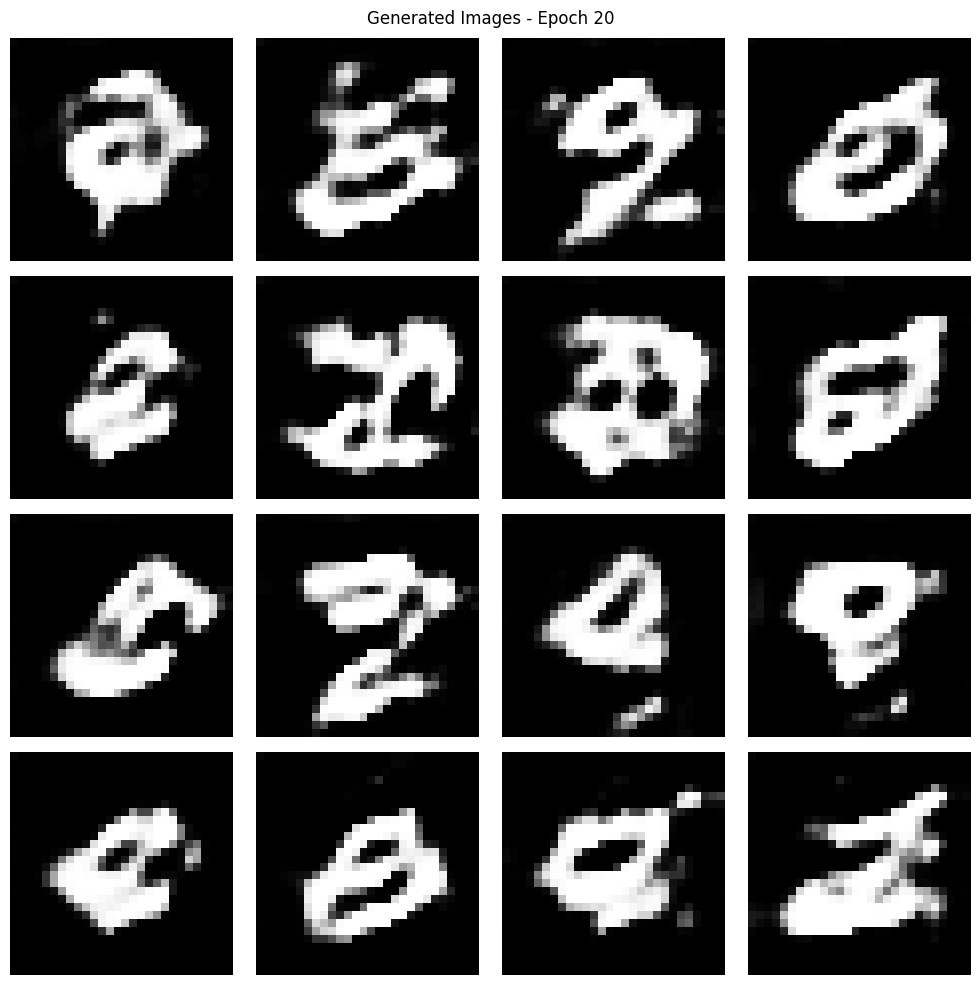

Epoch  20/20 - Gen Loss: 1.1861, Disc Loss: 1.0557, Time: 662.01s
Training completed!


In [8]:
def generate_and_save_images(model, epoch, test_input, save_dir='generated_images'):
    """
    Generate dan save images untuk visualisasi progress
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Generated Images - Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/epoch_{epoch:04d}.png')
    plt.show()

# Training parameters
EPOCHS = 20
BATCH_SIZE = 256
BUFFER_SIZE = 60000

# Prepare dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Fixed noise untuk consistent visualization
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_dim])

# Lists untuk menyimpan loss history
gen_losses = []
disc_losses = []

print("Starting GAN Training...")
print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}")

# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    epoch_gen_loss = []
    epoch_disc_loss = []

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch, BATCH_SIZE, latent_dim)
        epoch_gen_loss.append(gen_loss)
        epoch_disc_loss.append(disc_loss)

    # Calculate average losses
    avg_gen_loss = tf.reduce_mean(epoch_gen_loss)
    avg_disc_loss = tf.reduce_mean(epoch_disc_loss)

    gen_losses.append(avg_gen_loss.numpy())
    disc_losses.append(avg_disc_loss.numpy())

    # Generate images setiap 10 epochs
    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1:3d}/{EPOCHS} - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Time: {time.time()-start:.2f}s')

print("Training completed!")

# 8. VISUALISASI LOSS CURVES

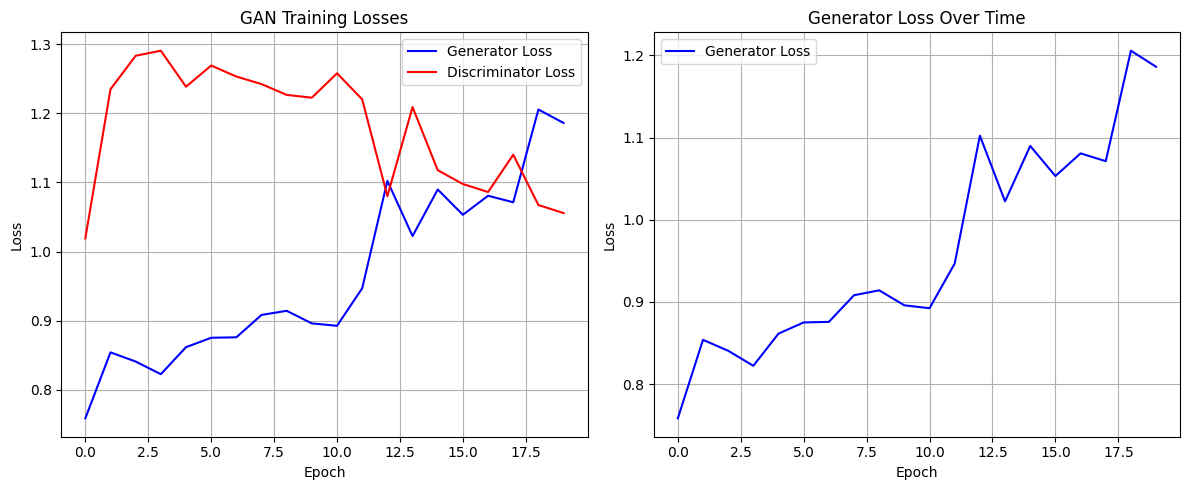

In [9]:
def plot_loss_curves(gen_losses, disc_losses):
    """
    Plot training loss curves
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(gen_losses, label='Generator Loss', color='blue')
    plt.plot(disc_losses, label='Discriminator Loss', color='red')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(gen_losses, label='Generator Loss', color='blue')
    plt.title('Generator Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss_curves(gen_losses, disc_losses)

# 9. EVALUASI HASIL GENERATOR

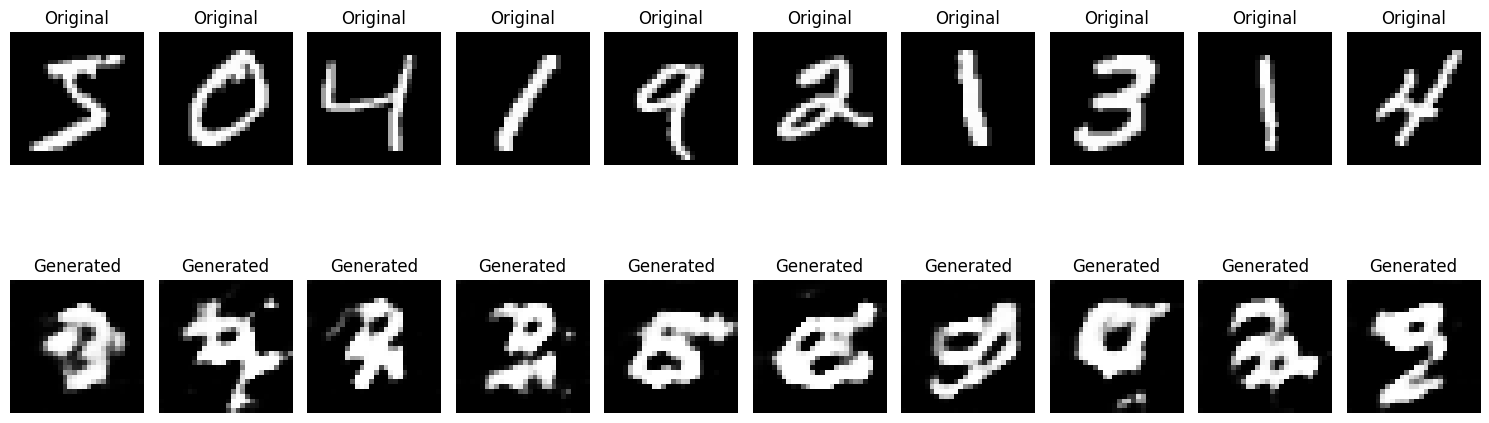

In [10]:
def generate_comparison_images(generator, original_data, n_samples=10):
    """
    Bandingkan gambar asli dengan generated images
    """
    # Generate random images
    noise = tf.random.normal([n_samples, latent_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(15, 6))

    # Plot original images
    for i in range(n_samples):
        plt.subplot(2, n_samples, i+1)
        plt.imshow(original_data[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot generated images
    for i in range(n_samples):
        plt.subplot(2, n_samples, n_samples + i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title('Generated')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate comparison
generate_comparison_images(generator, x_train)

# 10. ANALISIS HASIL GENERATOR SECARA BERKALA

=== ANALISIS KUALITAS GENERATOR ===


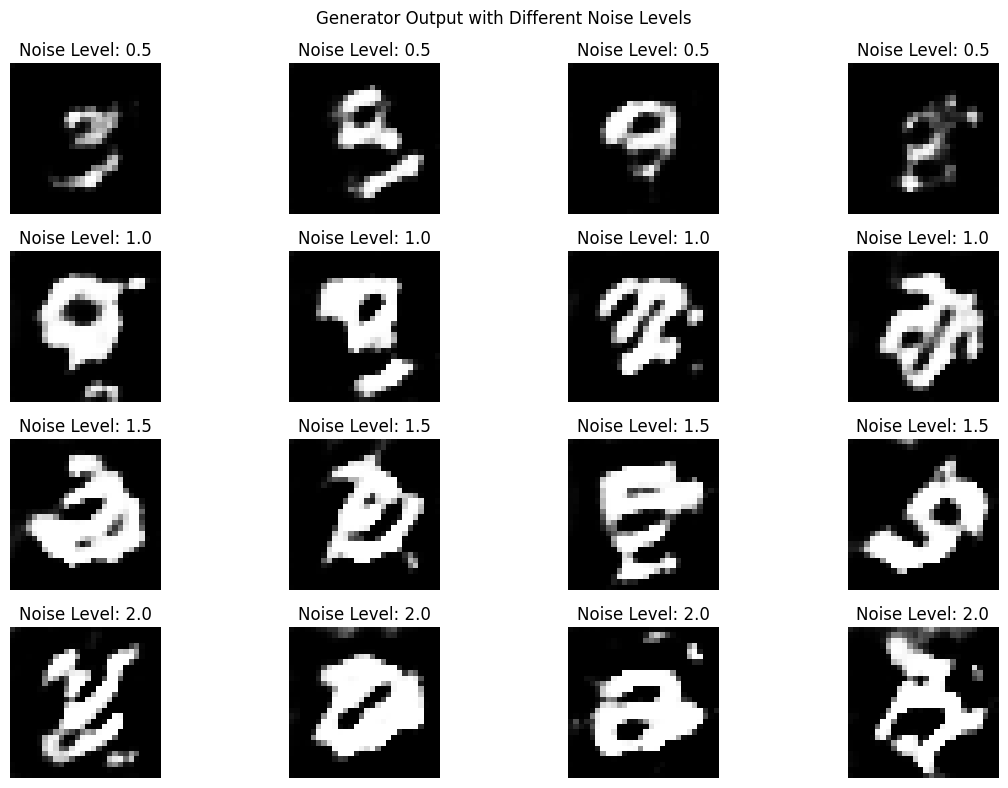

In [11]:
def analyze_generation_quality():

    print("=== ANALISIS KUALITAS GENERATOR ===")

    # Generate images dengan berbagai noise levels
    noise_levels = [0.5, 1.0, 1.5, 2.0]

    plt.figure(figsize=(12, 8))

    for idx, noise_level in enumerate(noise_levels):
        noise = tf.random.normal([4, latent_dim]) * noise_level
        generated = generator(noise, training=False)

        for i in range(4):
            plt.subplot(4, 4, idx * 4 + i + 1)
            plt.imshow(generated[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.title(f'Noise Level: {noise_level}')
            plt.axis('off')

    plt.suptitle('Generator Output with Different Noise Levels')
    plt.tight_layout()
    plt.show()

# Jalankan analisis
analyze_generation_quality()

# 11. MENYIMPAN MODEL

In [12]:
# Create models directory
if not os.path.exists('models'):
    os.makedirs('models')

# Save generator dan discriminator
generator.save('models/generator.h5')
discriminator.save('models/discriminator.h5')

print("Models saved successfully!")
print("- Generator: models/generator.h5")
print("- Discriminator: models/discriminator.h5")

# Save training history
np.save('models/generator_losses.npy', np.array(gen_losses))
np.save('models/discriminator_losses.npy', np.array(disc_losses))

print("Training history saved!")

Models saved successfully!
- Generator: models/generator.h5
- Discriminator: models/discriminator.h5
Training history saved!


# 12. FINAL EVALUATION DAN SUMMARY


FINAL EVALUATION - GAN TRAINING RESULTS
Total Training Epochs: 20
Final Generator Loss: 1.1861
Final Discriminator Loss: 1.0557

Generating final batch of images...


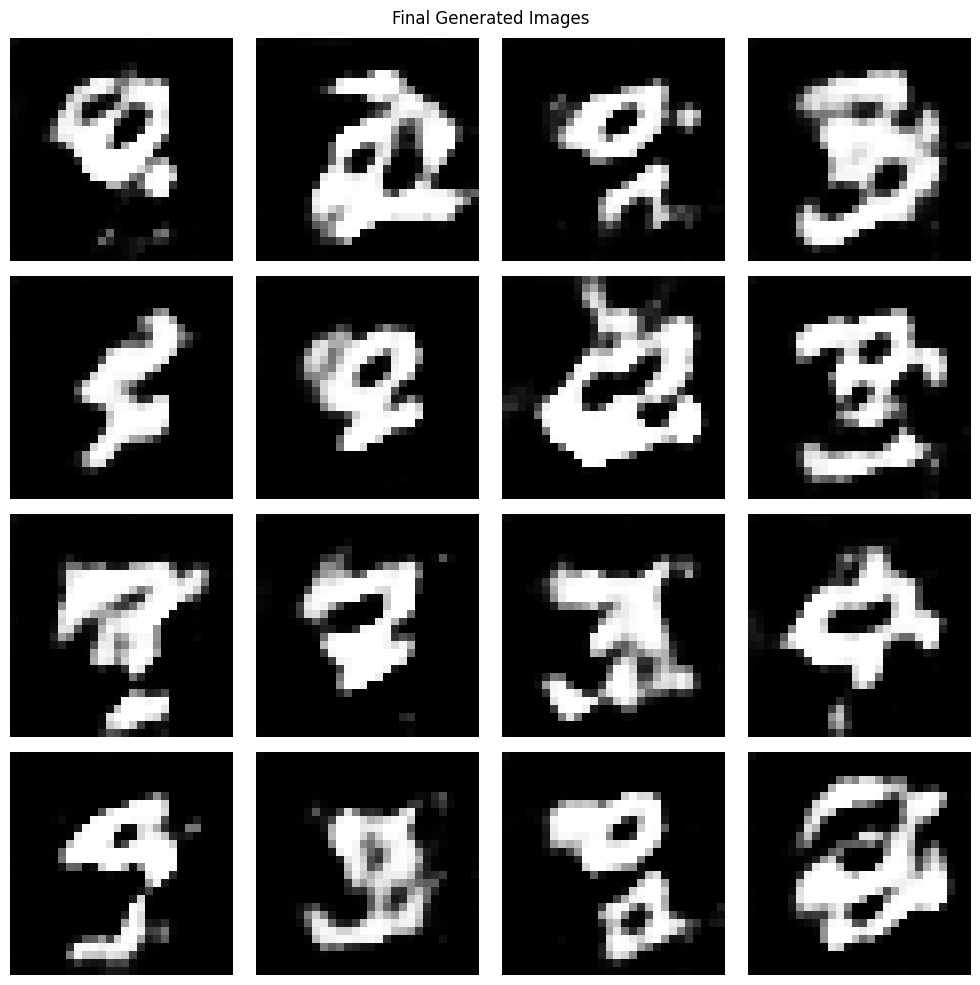


PERBEDAAN HASIL EPOCH AWAL VS AKHIR
Epoch Awal (Loss tinggi):
- Generator Loss: 0.7585
- Discriminator Loss: 1.0190

Epoch Akhir (Loss rendah):
- Generator Loss: 1.1861
- Discriminator Loss: 1.0557

Improvement Generator: -0.4276
Improvement Discriminator: -0.0367


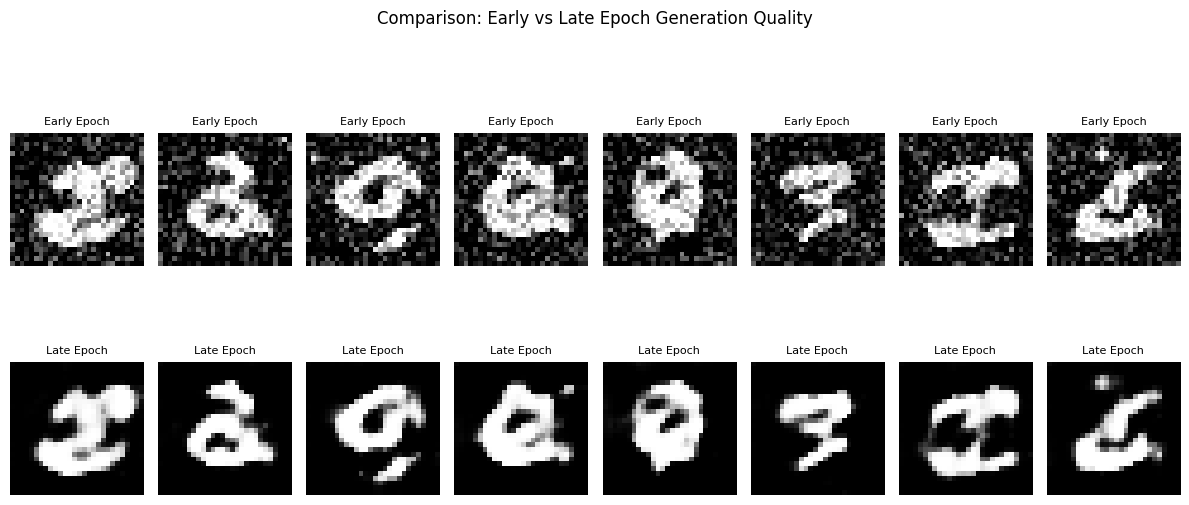

In [13]:
print("\n" + "="*60)
print("FINAL EVALUATION - GAN TRAINING RESULTS")
print("="*60)

print(f"Total Training Epochs: {EPOCHS}")
print(f"Final Generator Loss: {gen_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {disc_losses[-1]:.4f}")

# Generate final batch of images
print("\nGenerating final batch of images...")
final_noise = tf.random.normal([16, latent_dim])
final_generated = generator(final_noise, training=False)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(final_generated[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.suptitle('Final Generated Images')
plt.tight_layout()
plt.show()

# Analisis perbedaan epoch awal vs akhir
print("\n" + "="*60)
print("PERBEDAAN HASIL EPOCH AWAL VS AKHIR")
print("="*60)

print("Epoch Awal (Loss tinggi):")
print(f"- Generator Loss: {gen_losses[0]:.4f}")
print(f"- Discriminator Loss: {disc_losses[0]:.4f}")

print("\nEpoch Akhir (Loss rendah):")
print(f"- Generator Loss: {gen_losses[-1]:.4f}")
print(f"- Discriminator Loss: {disc_losses[-1]:.4f}")

improvement_gen = gen_losses[0] - gen_losses[-1]
improvement_disc = disc_losses[0] - disc_losses[-1]

print(f"\nImprovement Generator: {improvement_gen:.4f}")
print(f"Improvement Discriminator: {improvement_disc:.4f}")

# Visualisasi perbandingan epoch awal vs akhir
def compare_early_vs_late_generation():
    """
    Bandingkan hasil generator di epoch awal vs akhir
    """
    # Simulasi generator epoch awal (noise tinggi)
    noise = tf.random.normal([8, latent_dim])

    # Generate dengan model terlatih
    late_generation = generator(noise, training=False)

    # Simulasi early generation (tambah noise)
    early_simulation = late_generation + tf.random.normal(late_generation.shape) * 0.5
    early_simulation = tf.clip_by_value(early_simulation, -1, 1)

    plt.figure(figsize=(12, 6))

    # Early epoch simulation
    for i in range(8):
        plt.subplot(2, 8, i+1)
        plt.imshow(early_simulation[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title('Early Epoch', fontsize=8)
        plt.axis('off')

    # Late epoch (actual results)
    for i in range(8):
        plt.subplot(2, 8, 8+i+1)
        plt.imshow(late_generation[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title('Late Epoch', fontsize=8)
        plt.axis('off')

    plt.suptitle('Comparison: Early vs Late Epoch Generation Quality')
    plt.tight_layout()
    plt.show()

compare_early_vs_late_generation()